# Metasurface: microwave frequency selective surface (FSS) 

## Overview
We simulate microwave frequency selective surface (FSS) with 12GHz bandstop. periodic Metal cross array on dielectric substrate. Compare with Tidy3D example https://www.flexcompute.com/tidy3d/examples/notebooks/MicrowaveFrequencySelectiveSurface

## Geometry

running luminescent python frontenda


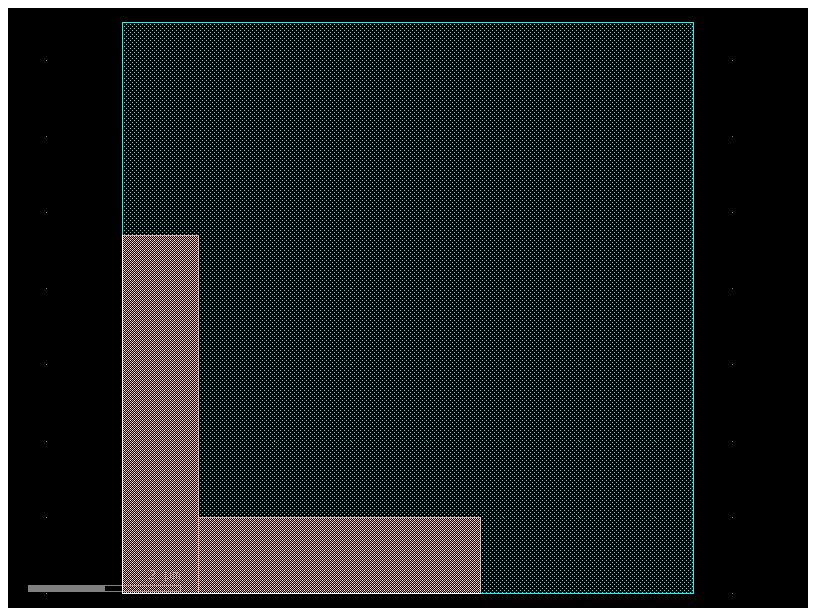

In [1]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import math
import numpy as np
import os
import matplotlib.pyplot as plt

# simulation folder
study='microwave_frequency_selective_surface'
path = os.path.join('studies', study)

# length and frequency units are arbitrary
frequency = 12  # origin frequency GHz
bw = 4  # bandwidth
df = 0.05  # frequency step
wl1f = 300  # vacuum wavelength at 1 unit of frequency in your units
wl = wl1f / frequency  # characteristic wavelength
frequencies = np.linspace(frequency-bw/2, frequency+bw/2, round(bw/df+1))

# unit cell [mm]
P = 15  # periodicity
L = 9.4  # length of cross
W = 2.0  # width of cross stub
d = 2.2  # height of substrate
th = 0.1  # metal thickness
gap = 30.0  # air gap below and above - keeps resonant evanescent field from coupling to lossy PML
margin = 2.0

# adaptive meshing
dx=W/5  # desired spatial resolution
nres = 16
dx0 = wl / nres
mesh_density = dx0 /dx

# material_library
material_library = lumi.MATERIAL_LIBRARY
material_library["sub"] = lumi.Material(epsilon=2.5, mesh_density=mesh_density)
material_library["PEC"] = lumi.PECMaterial(mesh_density=mesh_density)

# make geometry in gdsfactory. 1/4 section of unit cell due to symmetry
# alternatively can import .gds into gdsfactory

WG = (1, 0)
BBOX = (2, 0)

layer_stack = LayerStack(
    layers={
        "WG": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=th,
            zmin=0,
            material="PEC",
            mesh_order=1,
        ),
        "sub": LayerLevel(
            layer=LogicalLayer(layer=BBOX),
            thickness=d,
            zmin=-d,
            material="sub",
            mesh_order=2,
        ),
    }
)

c = gf.Component()
c.add_polygon(
    [(0, 0), (0, L / 2), (W / 2, L / 2), (W / 2, 0)],
    layer=WG,
)
p = c.add_polygon(
    [(W / 2, W / 2), (W / 2, 0), (L / 2, 0), (L / 2, W / 2)],
    layer=WG,
)
c.add_polygon([(0, 0), (0, P / 2), (P / 2, P / 2), (P / 2, 0)], layer=BBOX)
c.plot()

## Problem

In [2]:
xc = P / 4
yc = P / 4
ports = [
    lumi.PlanePort(
        name='o1',
        origin=[xc, yc, th + gap],
        frame=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    ),
    lumi.PlanePort(
        name='o2',
        origin=[xc, yc, -d- gap],
        frame=[[-1, 0, 0], [0, 1, 0], [0, 0, -1]],
    ),
]

nx=ny=round(P/2/dx)
a=np.ones((nx,ny))
modes = [lumi.Mode(
    frequencies=[frequency],
    fields=[[{"Ex": a, "Hy": a},{"Ey": a, "Hx": -a}]],
    start=[-P/4, -P/4],
    stop=[P/4, P/4],
    )]

sources = [lumi.Source("o1", source_port_margin=margin, frequency=frequency, bandwidth=bw)]

views=[lumi.View('Ex',x=0,y=0,z=th/2)]

# Luminescent community cluster client
email='paul@luminescentai.com'# replace with your registered email
client=lumi.Client(email,cluster='luminescent_community_cluster')

lumi.make(
    path,
    component=c,
    frequencies=frequencies,
    wl1f=wl1f,
    # antisymmetric/PEC/odd vs symmetric/PMC/even symmetry
    boundaries=["PEC", "PMC", "PML"],
    #
    sources=sources,
    ports=ports,
    modes=modes,
    zmin=-gap-d,
    zmax= th + gap + margin,
    #
    material_library=material_library,
    layer_stack=layer_stack,
    #
    relative_courant=0.9,  # relative courant number between 0 and 1
    nres=nres,
    tmax=50,  # max time [periods]
    energy_decay_threshold=0.001,  # field decay threshold for stopping simulation
    saveat=1,
    # visualization
    views=views,
    # 
    client=client,
)

saving mode plots to /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface/modes/1
using simulation folder /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface
0.2
Loading mesh from: /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface/geometry/1____PEC____WG____unnamed11.obj
0.2
Loading mesh from: /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface/geometry/3____sub____sub____unnamed31.obj
0.2
Loading mesh from: /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface/geometry/2____PEC____WG____unnamed21.obj


In [3]:
lumi.solve(path)

loading problem from /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface


servers:
['server0', 'STARTING']
['server1', 'TERMINATED']
['server2', 'ERROR']
['server3', 'ERROR']

job queue on luminescent_community_cluster:

submitted job to cluster luminescent_community_cluster
if you abort this python client, you'll also abort the job on the server!

backend loading simulation folder ...

CPU:
	threads: 48

GPU 0: NVIDIA RTX PRO 6000 Blackwell Server Edition
	CUDA Compute Capability: 12.0.0
	VRAM: 94.97076416015625 GB

setting up simulation...

meshing geometry
making sources...
making monitors...
making designs...

simulation config

backend: GPU
float: Float32

original size: (21, 21, 58)
padded size: (21, 21, 72)
cell count: 31,752

relative Courant number: 0.9
step size: 302.0 steps/period
source duration: 3.00 periods
max time: 53.00 periods    
energy decay threshold: 0.001

running simulation...

accumulating dft fields...
period 0.00, Inf seconds/period
pe

## Movie

Video generated successfully at /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface/simulation.gif!


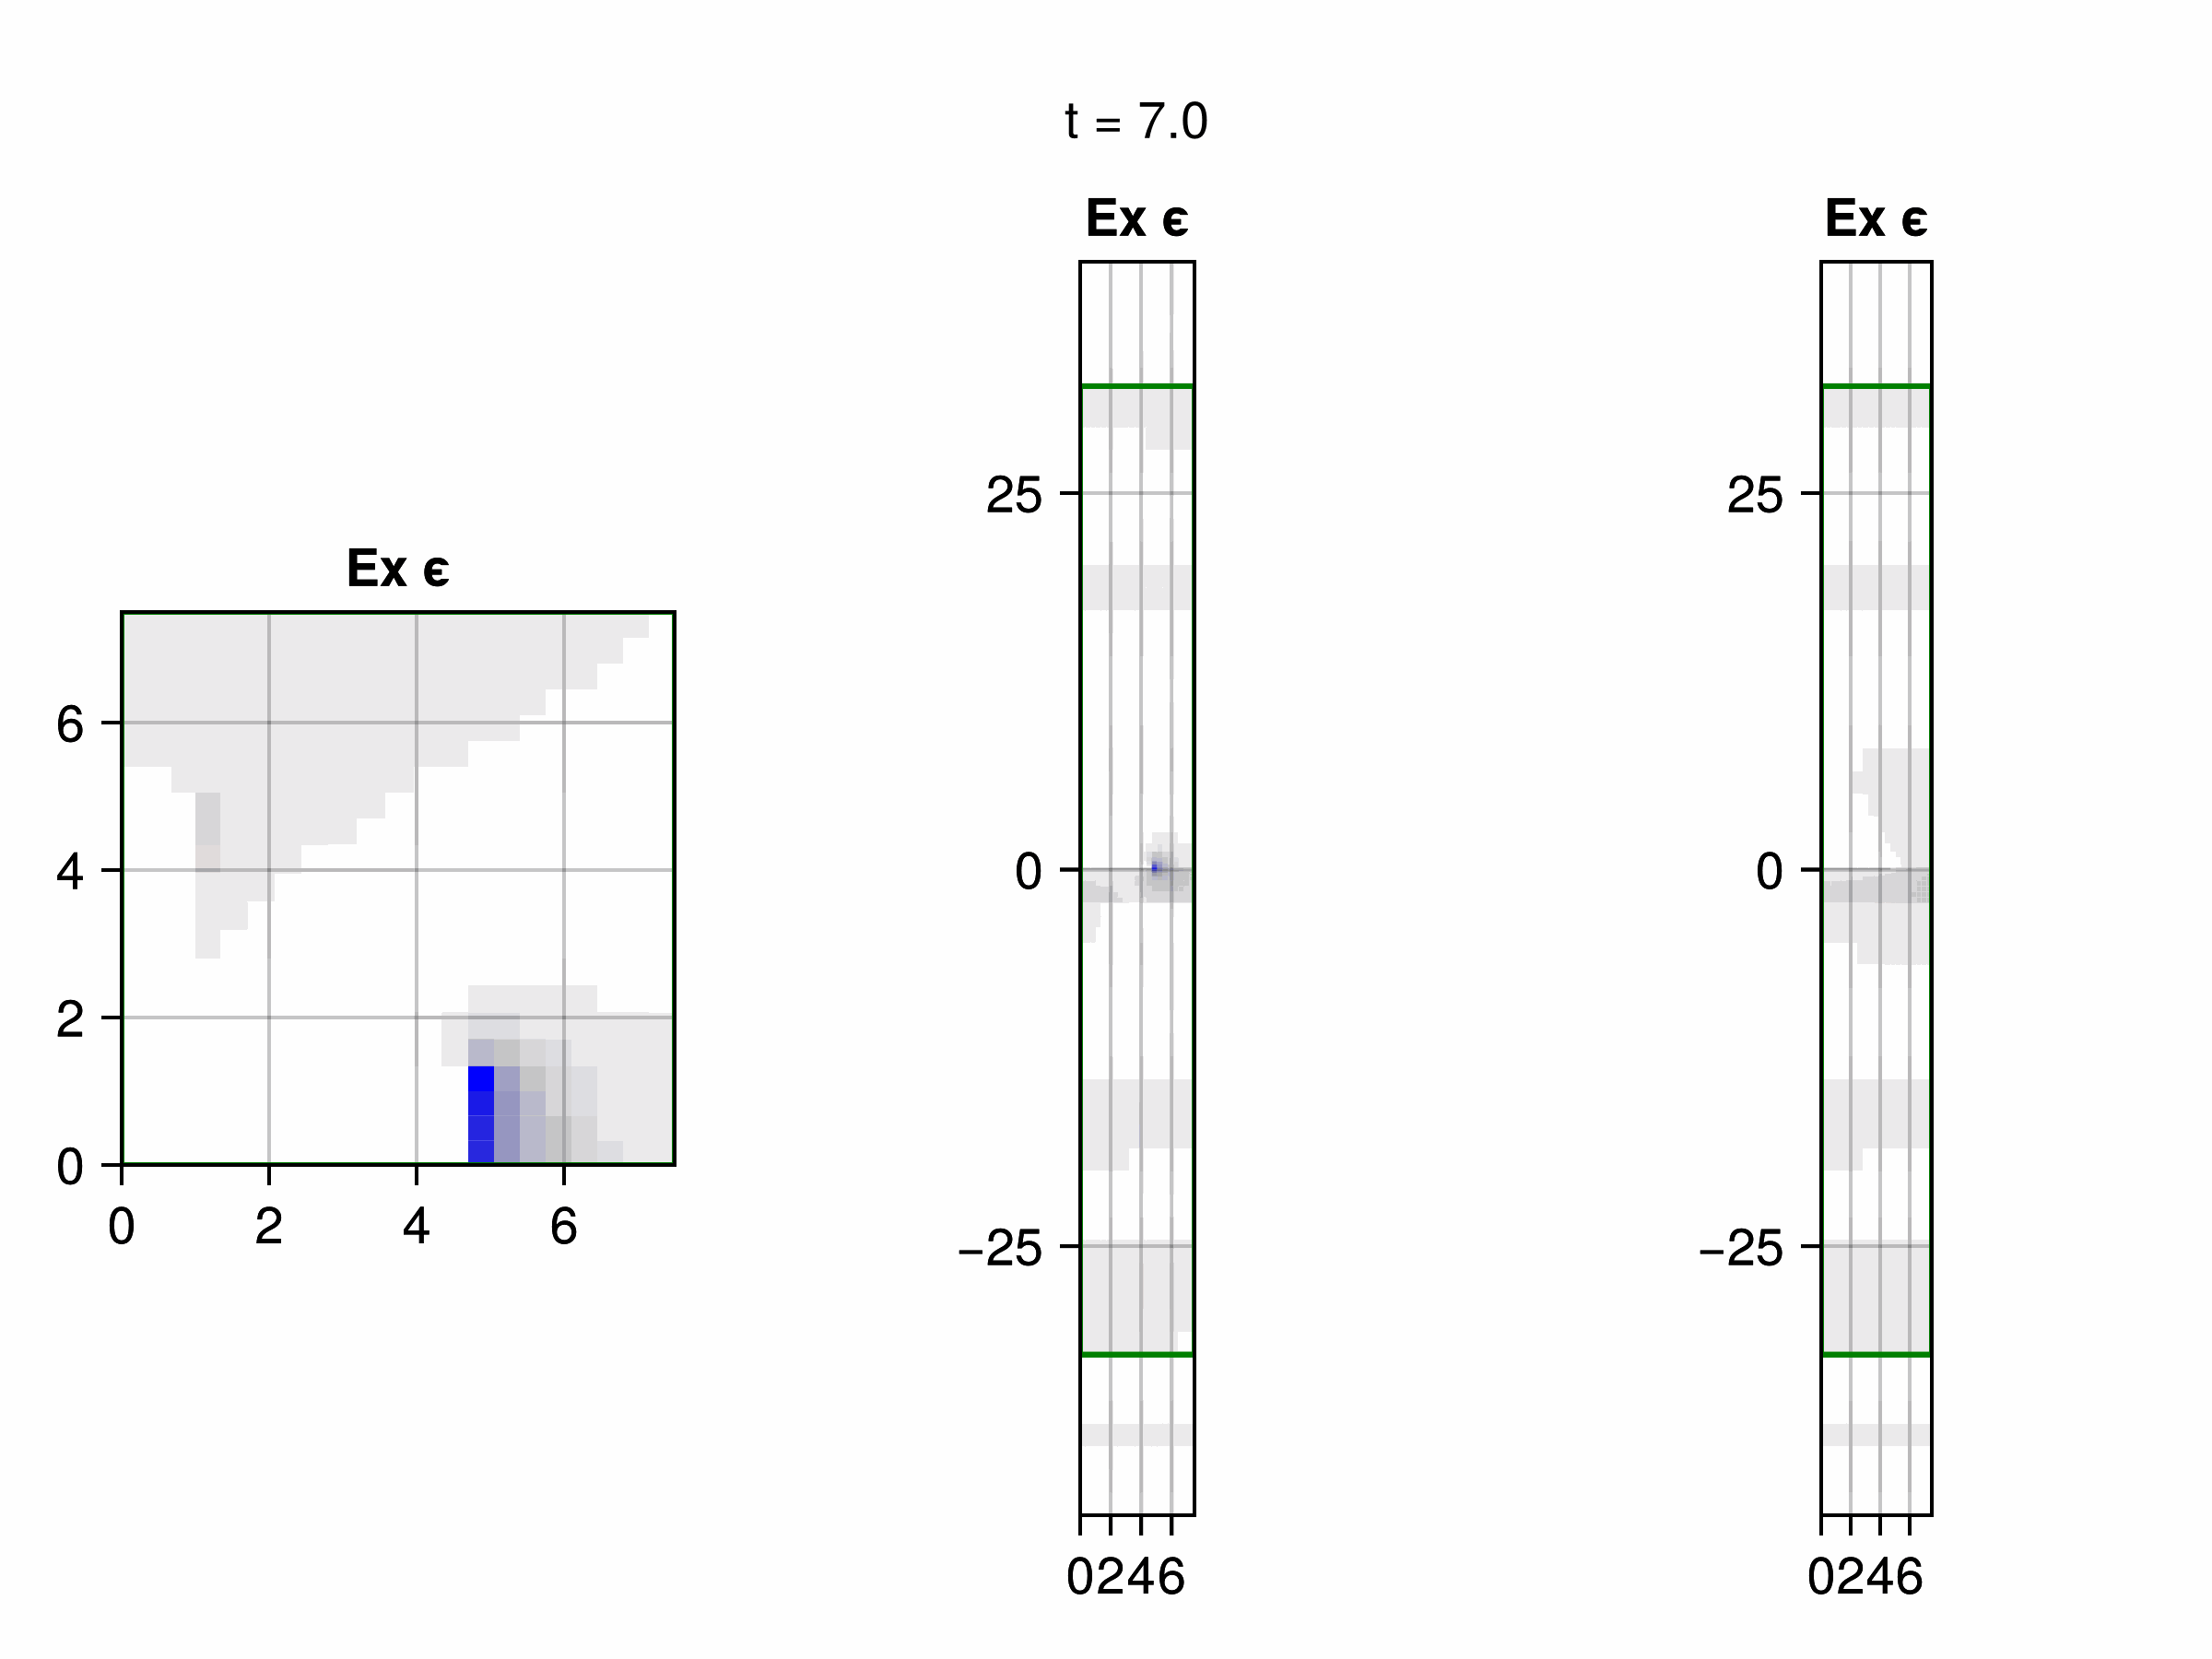

In [4]:
lumi.movie(path)

## Analysis

loading solution from /home/weihu/lumi/luminescent/studies/microwave_frequency_selective_surface
may take a minute if simulation folder is remotely mounted


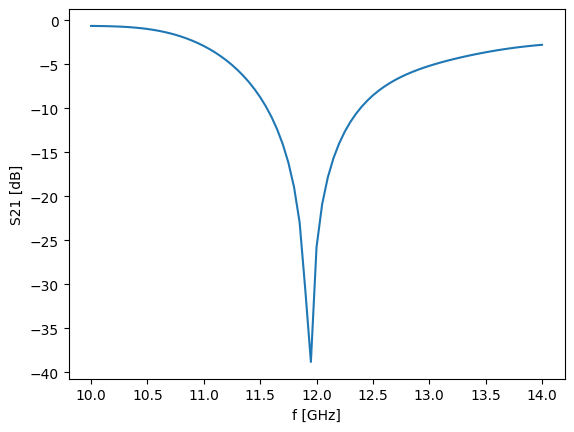

In [5]:
sol = lumi.load(path)
x = frequencies
y = [10 * math.log10(x) for x in lumi.query(sol,'T2,1')]
plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S21 [dB]")
plt.show()